In [96]:
import numpy as np
import pandas as pd

from sklearn.preprocessing              import MinMaxScaler 

from sklearn.model_selection            import train_test_split, ShuffleSplit
from sklearn.model_selection            import GridSearchCV
from sklearn.model_selection            import KFold

from sklearn.metrics                    import mean_absolute_error

from sklearn.preprocessing              import PolynomialFeatures

from sklearn.ensemble                   import RandomForestRegressor
from sklearn.ensemble                   import GradientBoostingRegressor
from sklearn.gaussian_process           import GaussianProcessRegressor  

from sklearn.linear_model               import LinearRegression

from sklearn.gaussian_process.kernels   import WhiteKernel, ExpSineSquared

import seaborn as sbn
import matplotlib.pyplot as plt 
%matplotlib inline


### DataSet paths

In [32]:
path_x_train =r"E:\Zabdesk\Tools and Techniques\Final project\dengue_features_train.csv"
path_y_train =r"E:\Zabdesk\Tools and Techniques\Final project\dengue_labels_train.csv"
path_x_test =r"E:\Zabdesk\Tools and Techniques\Final project\dengue_features_test.csv"
path_y_test =r""


### Global Functions

In [188]:
def DropQusMark(dataFrame) :
    cat_col = dataFrame.select_dtypes(include=['object']).copy()
    for x in cat_col.columns :
        dataFrame = dataFrame[~(dataFrame[x].str.contains('\?'))]
    return dataFrame

def ConvertToCat(dataFrame):
    cat_col = dataFrame.select_dtypes(include=['object']).copy()
    for x in cat_col.columns :
        dataFrame[x] = dataFrame[x].astype("category")
        dataFrame[x] = dataFrame[x].cat.codes
    return dataFrame

def RemoveMissingRow(dataFrame):
    dfnew = dataFrame
    for index, row in dataFrame.iterrows():
        if(pd.isnull(row["reanalysis_relative_humidity_percent"])):
            if(pd.isnull(row["reanalysis_sat_precip_amt_mm"])):
                dfnew = dfnew.drop([index])
    
    return dfnew

def JoinTestAndTrain(train_dataFrame, test_dataFrame):
    dfnew = [train_dataFrame, test_dataFrame]
    return pd.concat(dfnew, sort=False, axis = 0)

def SplitTestAndTrain(dataFrame):
    return [dataFrame.iloc[:1456,:] , dataFrame.iloc[1456:,:]]


### Merging DataSet

In [42]:
x_train_df = pd.read_csv(path_x_train)
x_train_df.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [43]:
y_train_df = pd.read_csv(path_y_train)
y_train_df.head()

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


In [49]:
main_df = pd.concat([x_train_df,y_train_df.iloc[:,3]], axis = 1)
main_df.head(5)

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


#### Loading actural test DataSet

In [57]:
test_df = pd.read_csv(path_x_test);
test_df.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


### DataSet Discription

### Train

#### DataSet Information

In [50]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 25 columns):
city                                     1456 non-null object
year                                     1456 non-null int64
weekofyear                               1456 non-null int64
week_start_date                          1456 non-null object
ndvi_ne                                  1262 non-null float64
ndvi_nw                                  1404 non-null float64
ndvi_se                                  1434 non-null float64
ndvi_sw                                  1434 non-null float64
precipitation_amt_mm                     1443 non-null float64
reanalysis_air_temp_k                    1446 non-null float64
reanalysis_avg_temp_k                    1446 non-null float64
reanalysis_dew_point_temp_k              1446 non-null float64
reanalysis_max_air_temp_k                1446 non-null float64
reanalysis_min_air_temp_k                1446 non-null float64
reanalysis_precip

#### Total null values in each column

In [51]:
main_df.isnull().sum()

city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_mi

### Test

#### DataSet Information

In [59]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416 entries, 0 to 415
Data columns (total 24 columns):
city                                     416 non-null object
year                                     416 non-null int64
weekofyear                               416 non-null int64
week_start_date                          416 non-null object
ndvi_ne                                  373 non-null float64
ndvi_nw                                  405 non-null float64
ndvi_se                                  415 non-null float64
ndvi_sw                                  415 non-null float64
precipitation_amt_mm                     414 non-null float64
reanalysis_air_temp_k                    414 non-null float64
reanalysis_avg_temp_k                    414 non-null float64
reanalysis_dew_point_temp_k              414 non-null float64
reanalysis_max_air_temp_k                414 non-null float64
reanalysis_min_air_temp_k                414 non-null float64
reanalysis_precip_amt_kg_per_m2  

#### Total null values in each column

In [60]:
test_df.isnull().sum()

city                                      0
year                                      0
weekofyear                                0
week_start_date                           0
ndvi_ne                                  43
ndvi_nw                                  11
ndvi_se                                   1
ndvi_sw                                   1
precipitation_amt_mm                      2
reanalysis_air_temp_k                     2
reanalysis_avg_temp_k                     2
reanalysis_dew_point_temp_k               2
reanalysis_max_air_temp_k                 2
reanalysis_min_air_temp_k                 2
reanalysis_precip_amt_kg_per_m2           2
reanalysis_relative_humidity_percent      2
reanalysis_sat_precip_amt_mm              2
reanalysis_specific_humidity_g_per_kg     2
reanalysis_tdtr_k                         2
station_avg_temp_c                       12
station_diur_temp_rng_c                  12
station_max_temp_c                        3
station_min_temp_c              

## ==========================Case # 1===================================

### Random Forest Regressor ( Default )

#### Filling missing values by column mean value

In [61]:
case_1_main_df = main_df.fillna(main_df.mean())
case_1_main_df.isnull().sum()

city                                     0
year                                     0
weekofyear                               0
week_start_date                          0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_pre

In [68]:
case_1_test_df = test_df.fillna(test_df.mean())
case_1_test_df.isnull().sum()

city                                     0
year                                     0
weekofyear                               0
week_start_date                          0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_pre

#### Converting catagorical column into numerical

In [62]:
case_1_main_df = ConvertToCat(case_1_main_df)
case_1_main_df.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,1,1990,18,0,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,1,1990,19,1,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,1,1990,20,2,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,1,1990,21,3,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,1,1990,22,4,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [69]:
case_1_test_df = ConvertToCat(case_1_test_df)
case_1_test_df.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,1,2008,18,0,-0.01890,-0.018900,0.102729,0.091200,78.60,298.492857,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,1,2008,19,1,-0.01800,-0.012400,0.082043,0.072314,12.56,298.475714,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,1,2008,20,2,-0.00150,0.126803,0.151083,0.091529,3.66,299.455714,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,1,2008,21,3,0.12605,-0.019867,0.124329,0.125686,0.00,299.690000,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,1,2008,22,4,0.05680,0.039833,0.062267,0.075914,0.76,299.780000,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


#### Removing "week_start_date" column becasue too many unique values

In [63]:
case_1_main_df = case_1_main_df.drop(['week_start_date'], axis=1);
case_1_main_df.head()

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,1,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,1,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,1,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,1,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,1,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [70]:
case_1_test_df = case_1_test_df.drop(['week_start_date'], axis=1);
case_1_test_df.head()

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,1,2008,18,-0.01890,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,1,2008,19,-0.01800,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,1,2008,20,-0.00150,0.126803,0.151083,0.091529,3.66,299.455714,299.357143,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,1,2008,21,0.12605,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,1,2008,22,0.05680,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


#### Spliting data into test and train set for testing model

In [86]:
X = case_1_main_df.iloc[:,:23]
Y = case_1_main_df.iloc[:,23]

In [87]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

#### Testing model

In [88]:
case_1_gbr = GradientBoostingRegressor(n_estimators=100)
case_1_gbr.fit(x_train, y_train)
case_1_gbr_result = case_1_gbr.predict(x_test)

mean_absolute_error(y_test, case_1_gbr_result)

14.301703266520178

### Now going to create submission file

In [89]:
case_1_gbr = GradientBoostingRegressor(n_estimators=100)
case_1_gbr.fit(X, Y)
case_1_gbr_result = case_1_gbr.predict(case_1_test_df)
len(case_1_gbr_result)

416

#### converting float to int

In [90]:
case_1_gbr_result = np.around(case_1_gbr_result)
case_1_gbr_result = case_1_gbr_result.astype(int)
len(case_1_gbr_result)

416

In [91]:
submission_df = test_df[["city","year","weekofyear"]]
submission_df.head()

,city,year,weekofyear
0,sj,2008,18
1,sj,2008,19
2,sj,2008,20
3,sj,2008,21
4,sj,2008,22


In [92]:
submission_df = pd.concat([submission_df,pd.DataFrame(case_1_gbr_result, columns=['total_cases'])], axis = 1)

In [94]:
submission_file = r"E:\Zabdesk\Tools and Techniques\Final project\submission_8.csv"
submission_df.to_csv(submission_file, sep=',', encoding='utf-8')
submission_df.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,8
1,sj,2008,19,5
2,sj,2008,20,6
3,sj,2008,21,8
4,sj,2008,22,10


#### Result 27.06

## ==========================Case # 2===================================

### Random Forest Regressor ( Default  2 )

In [110]:
main_total_cases = main_df["total_cases"].mean()
var_total_cases = main_df["total_cases"].var()
print('mean: ', main_total_cases)
print('var :', var_total_cases)

mean:  24.67513736263736
var : 1900.6112302216602


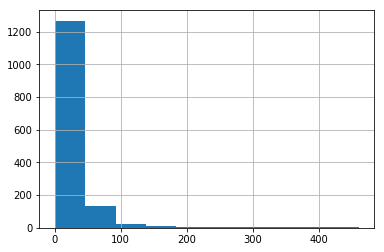

In [107]:
main_df["total_cases"].hist()

Text(0.5, 1.0, 'Correlations')

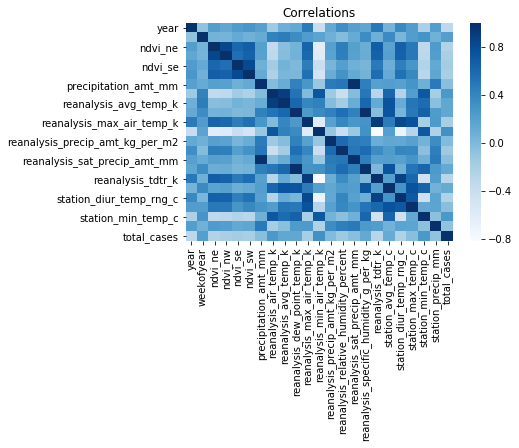

In [127]:
main_df_correlations = main_df.corr()
main_df_corr_heat = sbn.heatmap(main_df_correlations, cmap="Blues")
plt.title('Correlations')

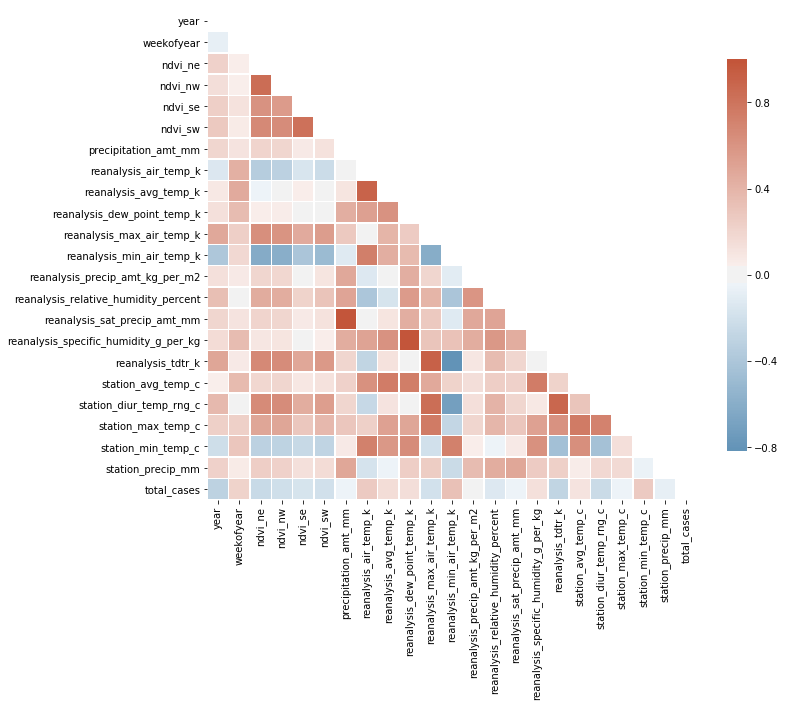

In [141]:
# Generate a mask for the upper triangle
mask = np.zeros_like(main_df_correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sbn.diverging_palette(240, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sbn.heatmap(main_df_correlations, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8})

In [144]:
main_df_correlations

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
year,1.000000,-0.071649,0.223361,0.144345,0.234234,0.277759,0.205302,-0.140016,0.085043,0.132273,...,0.336349,0.205302,0.161596,0.490542,0.047010,0.373644,0.227320,-0.214482,0.219910,-0.306806
weekofyear,-0.071649,1.000000,0.053548,0.048759,0.121557,0.068701,0.118037,0.425753,0.463677,0.348946,...,-0.015191,0.118037,0.350821,0.077933,0.368408,0.023220,0.232098,0.292362,0.066294,0.216452
ndvi_ne,0.223361,0.053548,1.000000,0.850902,0.614380,0.669504,0.205736,-0.340976,-0.037682,0.056077,...,0.457985,0.205736,0.094852,0.673935,0.186227,0.658129,0.491922,-0.315696,0.242263,-0.241376
ndvi_nw,0.144345,0.048759,0.850902,1.000000,0.555809,0.651938,0.193563,-0.317862,-0.030974,0.063289,...,0.449152,0.193563,0.100626,0.645596,0.203975,0.649483,0.490122,-0.304206,0.221314,-0.202235
ndvi_se,0.234234,0.121557,0.614380,0.555809,1.000000,0.820924,0.074633,-0.157447,0.051348,0.002810,...,0.215606,0.074633,0.028795,0.486047,0.089242,0.449599,0.290691,-0.251621,0.131326,-0.168612
ndvi_sw,0.277759,0.068701,0.669504,0.651938,0.820924,1.000000,0.124047,-0.227824,0.022533,0.020746,...,0.311759,0.124047,0.053437,0.569554,0.121060,0.545899,0.377393,-0.294684,0.158345,-0.196461
precipitation_amt_mm,0.205302,0.118037,0.205736,0.193563,0.074633,0.124047,1.000000,-0.017229,0.106384,0.434722,...,0.499984,1.000000,0.451202,0.201427,0.225408,0.193358,0.296215,0.076680,0.486637,-0.038740
reanalysis_air_temp_k,-0.140016,0.425753,-0.340976,-0.317862,-0.157447,-0.227824,-0.017229,1.000000,0.901777,0.529771,...,-0.402338,-0.017229,0.508380,-0.280375,0.619974,-0.261457,0.227768,0.719612,-0.173851,0.264952
reanalysis_avg_temp_k,0.085043,0.463677,-0.037682,-0.030974,0.051348,0.022533,0.106384,0.901777,1.000000,0.614268,...,-0.168371,0.106384,0.612484,0.124200,0.751330,0.107581,0.512220,0.579864,-0.048052,0.151637
reanalysis_dew_point_temp_k,0.132273,0.348946,0.056077,0.063289,0.002810,0.020746,0.434722,0.529771,0.614268,1.000000,...,0.553766,0.434722,0.997051,-0.033512,0.743506,0.037151,0.492319,0.651535,0.241335,0.142531


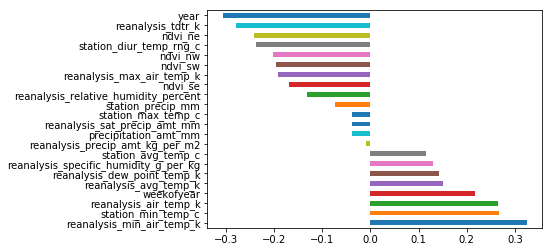

In [152]:
(main_df_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh())

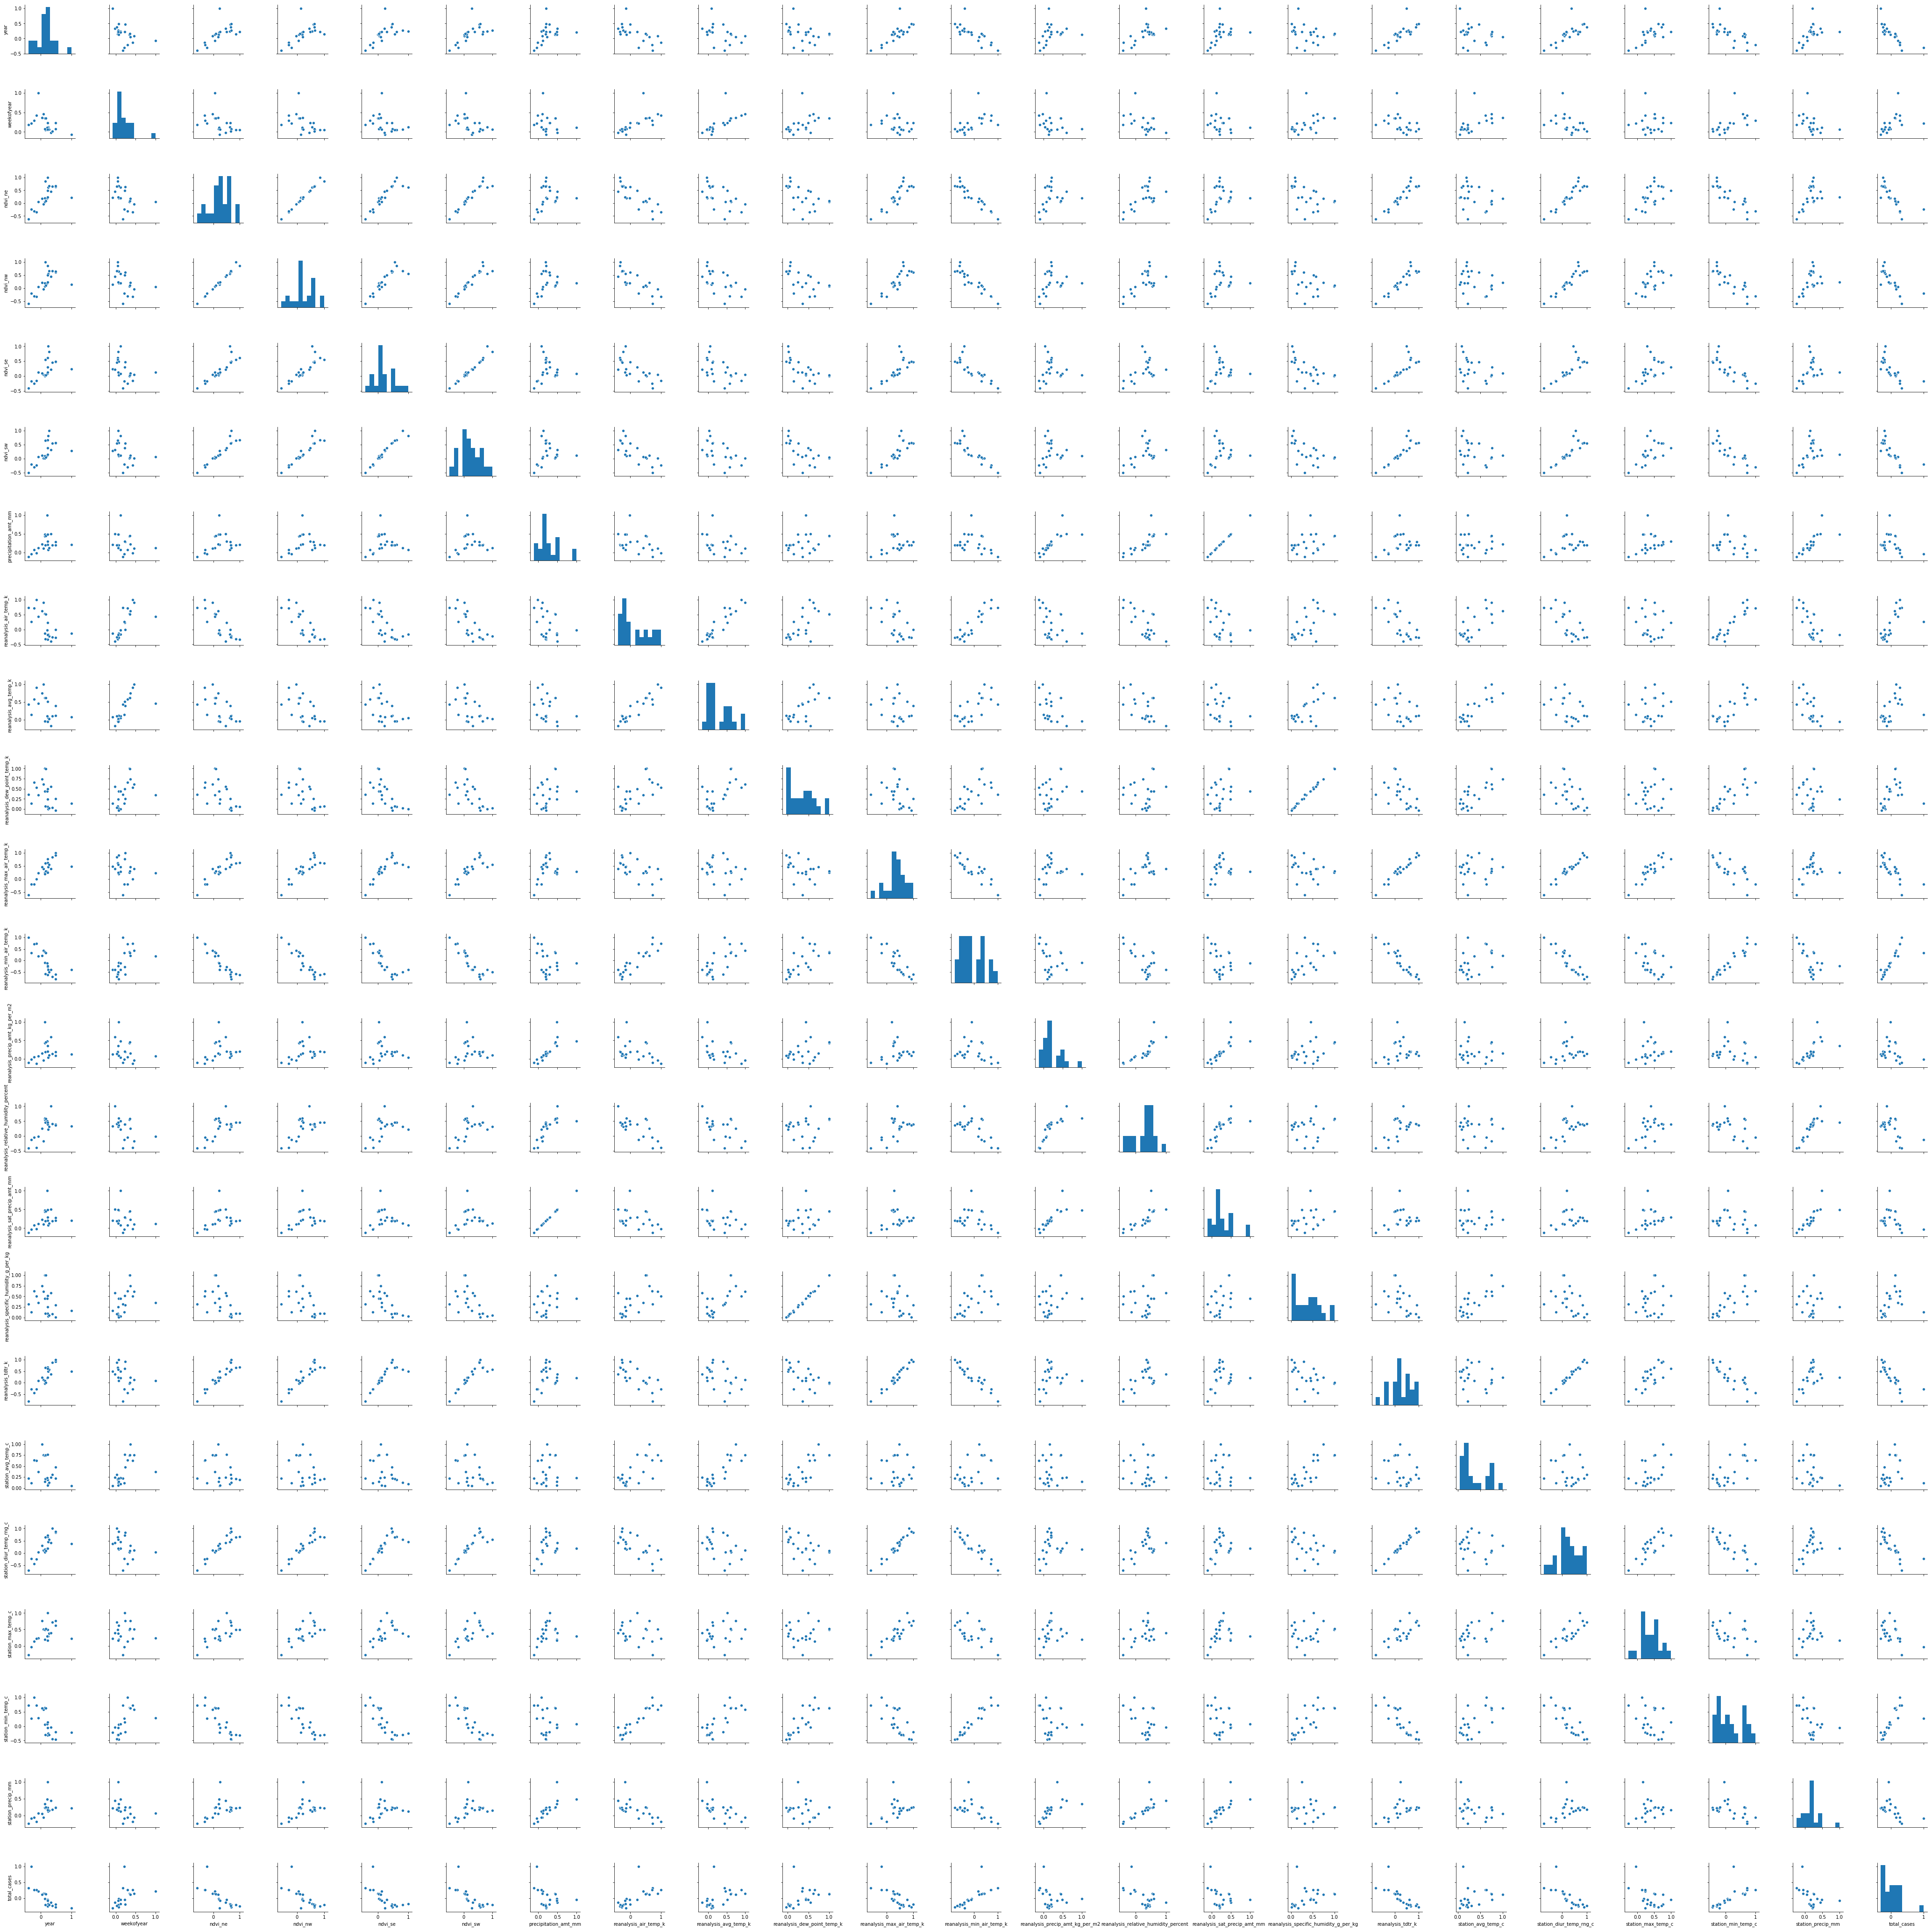

In [143]:
sbn.pairplot(main_df_correlations)

### Positive correlated featurs are : 
#### weekofyear , week_start_date, reanalysis_air_temp_k, station_min_temp_c

### Negetive correlated featurs are : 
#### year , ndvi_ne, ndvi_nw, ndvi_sw, station_diur_temp_rng_c

In [238]:
pos_features = ["weekofyear" ,"week_start_date", "reanalysis_air_temp_k", "station_min_temp_c"]
neg_features = ["year" , "ndvi_ne", "ndvi_nw", "ndvi_sw", "station_diur_temp_rng_c" ]

selected_features = np.concatenate([pos_features, neg_features]).tolist()
selected_features

['weekofyear',
 'week_start_date',
 'reanalysis_air_temp_k',
 'station_min_temp_c',
 'year',
 'ndvi_ne',
 'ndvi_nw',
 'ndvi_sw',
 'station_diur_temp_rng_c']

In [192]:
main_test_df = JoinTestAndTrain(main_df, test_df)

main_test_df = ConvertToCat(main_test_df)

re_main_df , re_test_df = SplitTestAndTrain(main_test_df)


In [195]:
re_main_df.head(5)

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,1,1990,18,0,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4.0
1,1,1990,19,1,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5.0
2,1,1990,20,2,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4.0
3,1,1990,21,3,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3.0
4,1,1990,22,4,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6.0


In [196]:
re_test_df.head(5)

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,1,2008,18,936,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,...,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2,NaN
1,1,2008,19,937,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,...,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3,NaN
2,1,2008,20,938,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,...,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0,NaN
3,1,2008,21,939,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,...,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3,NaN
4,1,2008,22,940,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,...,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1,NaN


In [227]:
re_main_df.isnull().sum()

city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_mi

In [228]:
re_test_df.isnull().sum()

city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                   43
ndvi_nw                                   11
ndvi_se                                    1
ndvi_sw                                    1
precipitation_amt_mm                       2
reanalysis_air_temp_k                      2
reanalysis_avg_temp_k                      2
reanalysis_dew_point_temp_k                2
reanalysis_max_air_temp_k                  2
reanalysis_min_air_temp_k                  2
reanalysis_precip_amt_kg_per_m2            2
reanalysis_relative_humidity_percent       2
reanalysis_sat_precip_amt_mm               2
reanalysis_specific_humidity_g_per_kg      2
reanalysis_tdtr_k                          2
station_avg_temp_c                        12
station_diur_temp_rng_c                   12
station_max_temp_c                         3
station_mi

In [224]:
submission_file = r"E:\Zabdesk\Tools and Techniques\Final project\re_main_df.csv"
re_main_df.to_csv(submission_file, sep=',', encoding='utf-8')
submission_file = r"E:\Zabdesk\Tools and Techniques\Final project\re_test_df.csv"
re_test_df.to_csv(submission_file, sep=',', encoding='utf-8')

In [229]:
case_2_main_df = re_main_df 
case_2_test_df = re_test_df

In [230]:
case_2_main_df = RemoveMissingRow(case_2_main_df)
case_2_main_df.isnull().sum()

city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  189
ndvi_nw                                   47
ndvi_se                                   17
ndvi_sw                                   17
precipitation_amt_mm                       3
reanalysis_air_temp_k                      0
reanalysis_avg_temp_k                      0
reanalysis_dew_point_temp_k                0
reanalysis_max_air_temp_k                  0
reanalysis_min_air_temp_k                  0
reanalysis_precip_amt_kg_per_m2            0
reanalysis_relative_humidity_percent       0
reanalysis_sat_precip_amt_mm               3
reanalysis_specific_humidity_g_per_kg      0
reanalysis_tdtr_k                          0
station_avg_temp_c                        33
station_diur_temp_rng_c                   33
station_max_temp_c                        10
station_mi

In [232]:
case_2_main_df.fillna(method='ffill', inplace=True)
case_2_main_df.isnull().sum()

city                                     0
year                                     0
weekofyear                               0
week_start_date                          0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_pre

In [234]:
case_2_test_df.fillna(method='ffill', inplace=True)
case_2_test_df.isnull().sum()

city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                    0
ndvi_nw                                    0
ndvi_se                                    0
ndvi_sw                                    0
precipitation_amt_mm                       0
reanalysis_air_temp_k                      0
reanalysis_avg_temp_k                      0
reanalysis_dew_point_temp_k                0
reanalysis_max_air_temp_k                  0
reanalysis_min_air_temp_k                  0
reanalysis_precip_amt_kg_per_m2            0
reanalysis_relative_humidity_percent       0
reanalysis_sat_precip_amt_mm               0
reanalysis_specific_humidity_g_per_kg      0
reanalysis_tdtr_k                          0
station_avg_temp_c                         0
station_diur_temp_rng_c                    0
station_max_temp_c                         0
station_mi

In [235]:
case_2_test_df = case_2_test_df.drop(['total_cases'], axis=1);

In [236]:
case_2_test_df.isnull().sum()

city                                     0
year                                     0
weekofyear                               0
week_start_date                          0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_pre

In [239]:
selected_features.append("total_cases")

In [240]:
selected_features

['weekofyear',
 'week_start_date',
 'reanalysis_air_temp_k',
 'station_min_temp_c',
 'year',
 'ndvi_ne',
 'ndvi_nw',
 'ndvi_sw',
 'station_diur_temp_rng_c',
 'total_cases']

In [241]:
case_2_main_df = case_2_main_df[selected_features]

case_2_main_df.head(5)

,weekofyear,week_start_date,reanalysis_air_temp_k,station_min_temp_c,year,ndvi_ne,ndvi_nw,ndvi_sw,station_diur_temp_rng_c,total_cases
0,18,0,297.572857,20.0,1990,0.122600,0.103725,0.177617,6.900000,4.0
1,19,1,298.211429,22.2,1990,0.169900,0.142175,0.155486,6.371429,5.0
2,20,2,298.781429,22.8,1990,0.032250,0.172967,0.170843,6.485714,4.0
3,21,3,298.987143,23.3,1990,0.128633,0.245067,0.235886,6.771429,3.0
4,22,4,299.518571,23.9,1990,0.196200,0.262200,0.247340,9.371429,6.0


In [263]:
case_2_test_col = ['weekofyear', 'week_start_date', 'reanalysis_air_temp_k', 
                  'station_min_temp_c', 'year', 'ndvi_ne', 
                  'ndvi_nw', 'ndvi_sw', 'station_diur_temp_rng_c']

case_2_test_df = case_2_test_df[case_2_test_col]

case_2_main_df.head(5)

,weekofyear,week_start_date,reanalysis_air_temp_k,station_min_temp_c,year,ndvi_ne,ndvi_nw,ndvi_sw,station_diur_temp_rng_c,total_cases
0,18,0,297.572857,20.0,1990,0.122600,0.103725,0.177617,6.900000,4.0
1,19,1,298.211429,22.2,1990,0.169900,0.142175,0.155486,6.371429,5.0
2,20,2,298.781429,22.8,1990,0.032250,0.172967,0.170843,6.485714,4.0
3,21,3,298.987143,23.3,1990,0.128633,0.245067,0.235886,6.771429,3.0
4,22,4,299.518571,23.9,1990,0.196200,0.262200,0.247340,9.371429,6.0


In [264]:
case_2_test_df.head(5)

,weekofyear,week_start_date,reanalysis_air_temp_k,station_min_temp_c,year,ndvi_ne,ndvi_nw,ndvi_sw,station_diur_temp_rng_c
0,18,936,298.492857,21.7,2008,-0.0189,-0.018900,0.091200,7.057143
1,19,937,298.475714,22.2,2008,-0.0180,-0.012400,0.072314,5.557143
2,20,938,299.455714,22.8,2008,-0.0015,-0.012400,0.091529,7.785714
3,21,939,299.690000,24.4,2008,-0.0015,-0.019867,0.125686,6.271429
4,22,940,299.780000,23.3,2008,0.0568,0.039833,0.075914,7.085714


In [266]:
X = case_2_main_df.iloc[:,:9]
Y = case_2_main_df.iloc[:,9]

In [268]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

In [269]:
case_2_gbr = GradientBoostingRegressor(n_estimators=120)
case_2_gbr.fit(x_train, y_train)
case_2_gbr_result = case_2_gbr.predict(x_test)

mean_absolute_error(y_test, case_2_gbr_result)

11.123967093275473

In [271]:
case_2_gbr = GradientBoostingRegressor(n_estimators=120)
case_2_gbr.fit(X, Y)
case_2_gbr_result = case_2_gbr.predict(case_2_test_df)
len(case_2_gbr_result)

416

In [277]:
case_2_gbr_result = np.around(case_2_gbr_result)
case_2_gbr_result = case_2_gbr_result.astype(int)
len(case_2_gbr_result)

416

In [278]:
submission_df = test_df[["city","year","weekofyear"]]
submission_df.head(3)

,city,year,weekofyear
0,sj,2008,18
1,sj,2008,19
2,sj,2008,20


In [279]:
submission_df = pd.concat([submission_df,pd.DataFrame(case_2_gbr_result, columns=['total_cases'])], axis = 1)

In [280]:
submission_file = r"E:\Zabdesk\Tools and Techniques\Final project\submission_11.csv"
submission_df.to_csv(submission_file, sep=',', encoding='utf-8')
submission_df.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,7
1,sj,2008,19,10
2,sj,2008,20,11
3,sj,2008,21,20
4,sj,2008,22,11


#### MAE on site : 26.8  

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

### Gradient Boosting Regressor

In [14]:
gradient_rgs = GradientBoostingRegressor(n_estimators=100)
gradient_rgs.fit(x_train, y_train)
gradient_rgs_result = gradient_rgs.predict(x_test)

print(mean_absolute_error(y_test, gradient_rgs_result)) 
print ("R-squared for Train: %.2f" %gradient_rgs.score(x_train, y_train))
print ("R-squared for Test: %.2f" %gradient_rgs.score(x_test, y_test))

12.770618892588207
R-squared for Train: 0.93
R-squared for Test: 0.63


In [165]:
def GradientBooster(param_grid, n_jobs): 
    estimator = GradientBoostingRegressor() 
    cv = ShuffleSplit(n_splits = x_train.shape[0], random_state=10, test_size=0.3) 
    classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs)
    return cv, classifier 


In [164]:
param_grid = {  
    'n_estimators':[100], 
    'learning_rate': [0.1],# 0.05, 0.02, 0.01], 
    'max_depth':[6],#4,6], 
    'min_samples_leaf':[3],#,5,9,17], 
    'max_features':[1.0],#,0.3]#,0.1] 
}
    
n_jobs=4 

cv , best_est = GradientBooster(param_grid, n_jobs)

gradient_rgs = best_est
gradient_rgs.fit(x_train, y_train)
gradient_rgs_result = gradient_rgs.predict(x_test)     

print(mean_absolute_error(y_test, gradient_rgs_result)) 

12.03570564582106


In [169]:
parameters = {  
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": [3,9,17],
    "max_depth":[3,5,8],
    "max_features":[1.0,0.3] ,
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.8, 0.9, 1.0],
    "n_estimators":[10]
}
    
n_jobs=5

best_est = clf = GridSearchCV(GradientBoostingRegressor(), parameters, cv=10, n_jobs=-1, verbose = 5)

gradient_rgs = best_est
gradient_rgs.fit(x_train, y_train)
gradient_rgs_result = gradient_rgs.predict(x_test)     

print(mean_absolute_error(y_test, gradient_rgs_result)) 

C:\Users\Hamza\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


13.985121673102618


### Train with full data

In [21]:
gradient_rgs = GradientBoostingRegressor(n_estimators=100)
gradient_rgs.fit(X, Y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

#### Now Testing on real data

In [18]:
df_act = df_act.drop(['ndvi_ne'], axis=1);
df_act = df_act.drop(['ndvi_nw'], axis=1);
df_act = df_act.drop(['week_start_date'], axis=1);

df_act.head()

,city,year,weekofyear,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,1,2008,18,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,1,2008,19,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,1,2008,20,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,1,2008,21,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,1,2008,22,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


In [22]:
gradient_rgs_result_act = gradient_rgs.predict(df_act)
round_df_array =  gradient_rgs_result_act.astype(int)
round_df_array

array([  6,   5,   5,  25,   8,  19,   9,   9,  23,  27,  26,  31,  35,
        46,  65,  52,  31,  58,  78,  54,  52,  24,  21,  48,  26,  21,
        25,  25,  25,  24,  21,  11,  13,  13,  11,  15,  15,  17,  16,
        15,  13,  11,  13,   9,   9,   5,   7,   9,   4,   6,   5,   4,
         5,   5,   5,   5,   8,   8,  10,  10,   7,  27,  42,  41,  47,
        59,  51,  51,  46,  55,  53,  27,  62,  59,  65,  61,  59,  57,
        53,  41,  22,  28,  24,  34,  29,  22,  19,  15,  19,  19,  15,
        17,  15,  13,  11,  11,  11,   8,   7,   6,   8,   6,   5,   7,
         8,   9,   8,  14,  12,  70,  72,  38,  19,  35,  66,  63,  46,
        37,  60, 101,  85,  79, 130,  93,  81,  68,  50,  60,  85,  46,
        50,  25,  23,  21,  18,  12,  11,  17,  13,  12,  14,  15,  19,
        18,  17,  12,  12,  12,   9,   8,   6,   7,   7,   1,  22,   4,
         6,   6,   4,   8,   8,  11,   8,  47,  94,  51,  19,  34,  26,
        78,  27,  75,  54,  95,  52,  53,  59,  15,  34,  67,  6

In [23]:
around_df_array = np.around(gradient_rgs_result_act)
around_df_array = around_df_array.astype(int)
around_df_array

array([  7,   5,   6,  25,   9,  19,  10,   9,  24,  28,  27,  32,  35,
        47,  65,  53,  31,  59,  78,  54,  53,  24,  22,  48,  27,  22,
        26,  25,  26,  24,  21,  12,  14,  13,  12,  15,  15,  18,  16,
        16,  13,  12,  14,  10,   9,   6,   7,   9,   5,   6,   6,   4,
         6,   5,   6,   5,   9,   9,  10,  10,   7,  27,  42,  41,  48,
        60,  51,  51,  47,  55,  54,  28,  62,  60,  65,  61,  59,  58,
        53,  41,  23,  29,  24,  34,  30,  22,  20,  15,  19,  19,  15,
        18,  15,  14,  12,  11,  11,   9,   8,   7,   9,   7,   6,   7,
         9,  10,   9,  14,  13,  71,  73,  38,  20,  36,  66,  64,  46,
        38,  61, 101,  86,  80, 131,  93,  81,  68,  50,  60,  86,  47,
        51,  26,  24,  22,  19,  13,  12,  17,  13,  13,  15,  16,  19,
        18,  18,  12,  13,  12,  10,   9,   6,   8,   8,   2,  22,   5,
         6,   7,   5,   8,   8,  11,   9,  47,  95,  51,  19,  35,  27,
        78,  28,  76,  55,  95,  53,  54,  59,  16,  34,  67,  6

In [26]:
df_subm = pd.read_csv(path_x_test);
df_subm = df_subm[["city","year","weekofyear"]]

df_subm.head()

,city,year,weekofyear
0,sj,2008,18
1,sj,2008,19
2,sj,2008,20
3,sj,2008,21
4,sj,2008,22


In [27]:
df_subm_4 = pd.concat([df_subm,pd.DataFrame(round_df_array, columns=['total_cases'])], axis = 1)

In [29]:
df_subm_4.head(5)

,city,year,weekofyear,total_cases
0,sj,2008,18,6
1,sj,2008,19,5
2,sj,2008,20,5
3,sj,2008,21,25
4,sj,2008,22,8


In [31]:
submission_file = r"E:\Zabdesk\Tools and Techniques\Final project\submission_6.csv"
df_subm_4.to_csv(submission_file, sep=',', encoding='utf-8')

df_subm_4.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,6
1,sj,2008,19,5
2,sj,2008,20,5
3,sj,2008,21,25
4,sj,2008,22,8


#### MAE on site : 26.4  

### GaussianProcessRegressor

In [48]:
ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1))

ExpSineSquared(length_scale=1, periodicity=5)

In [101]:
gp_kernel = ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1)) \
+ WhiteKernel(noise_level=.01)
gp_kernel

ExpSineSquared(length_scale=1, periodicity=5) + WhiteKernel(noise_level=0.01)

In [102]:

gaussian_rgs = GaussianProcessRegressor(kernel=gp_kernel,
                                        alpha=40,
                                        random_state=6)
gaussian_rgs.fit(X, Y)

GaussianProcessRegressor(alpha=40, copy_X_train=True,
             kernel=ExpSineSquared(length_scale=1, periodicity=5) + WhiteKernel(noise_level=0.01),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=6)

In [106]:
gaussian_rgs.fit(x_train, y_train)
y_gpr = gaussian_rgs.predict(x_test)


mean_absolute_error(y_test, y_gpr)

20.79211710971811

### RandomForestRegressor

In [109]:
random_rgs = RandomForestRegressor()
random_rgs.fit(x_train, y_train)
y_rgs = random_rgs.predict(x_test)

mean_absolute_error(y_test, y_rgs)

C:\Users\Hamza\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


14.808577405857742